In [2]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
import pandas as pd
def obj_func(b, x, y):
    return np.sum((x + b - y) ** 2)

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

In [3]:
overlap_df = pd.read_csv(os.path.join('/home/mmccraw/dev/data/09-27-25/finding-hard-particle-limit/', 'aggregated-data.csv'))
overlap_df = overlap_df[(overlap_df.temp < 5e-6)]

def get_max_phi(overlap_df, mu, nv, overlap_factor):
    df = overlap_df[np.isclose(overlap_df.nv, nv) & (np.isclose(overlap_df.mu, mu))]
    x = df.phi.values
    y = df.avg_dim_overlap.values
    order = np.argsort(x)
    x = x[order]
    y = y[order]
    mask = y < np.mean(y[:10]) * overlap_factor
    return np.max(x[mask])

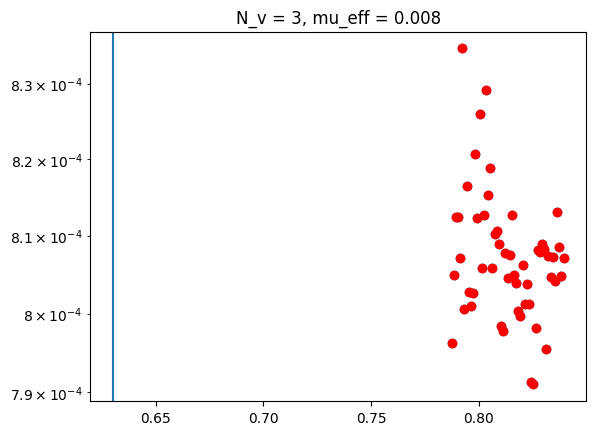

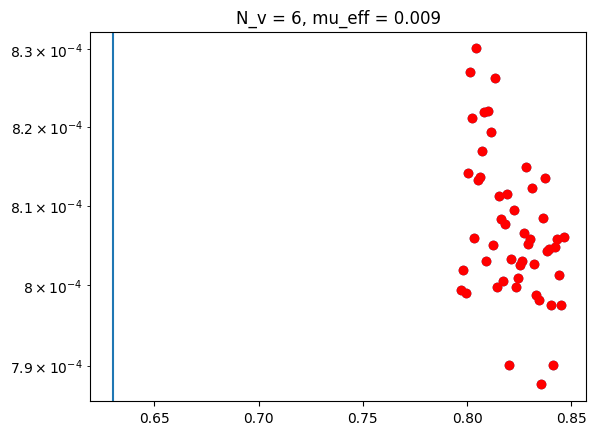

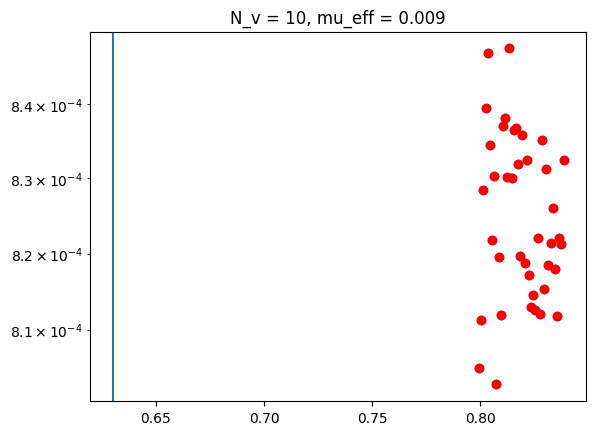

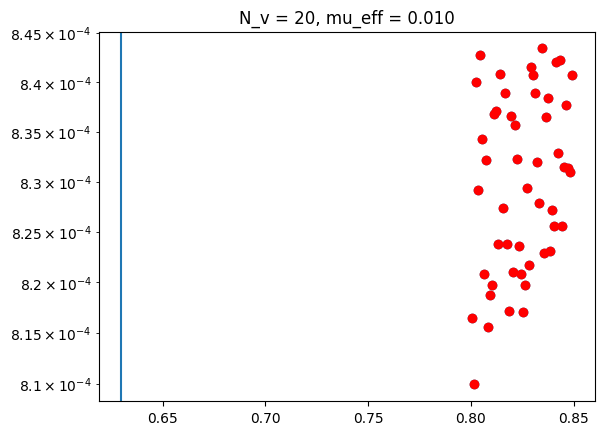

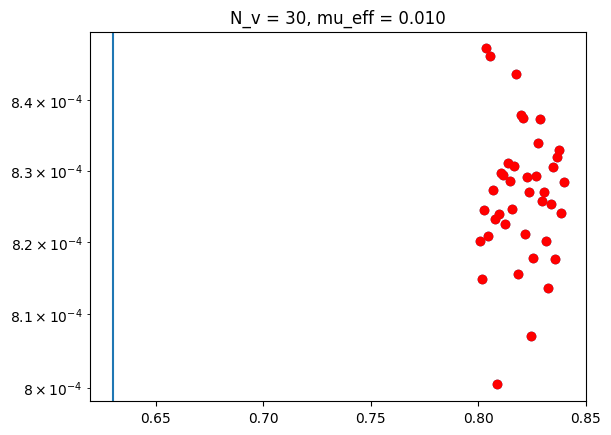

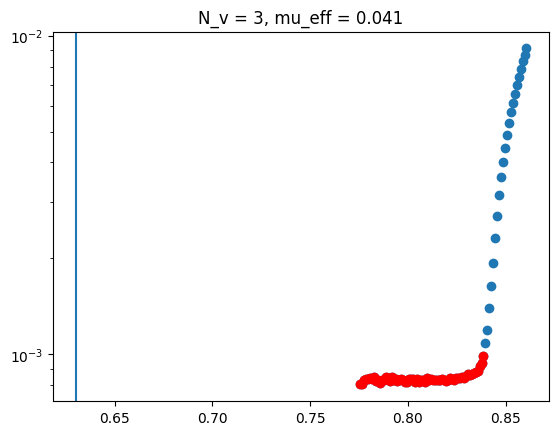

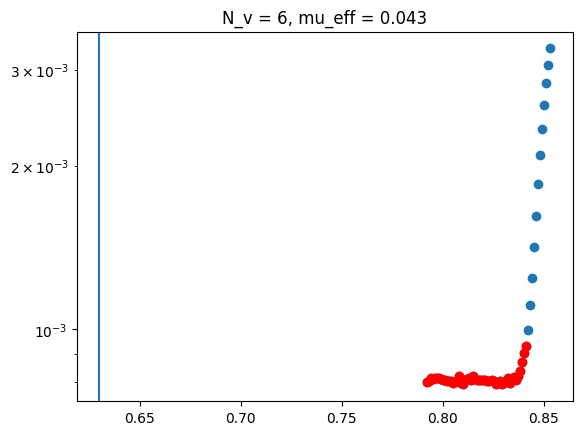

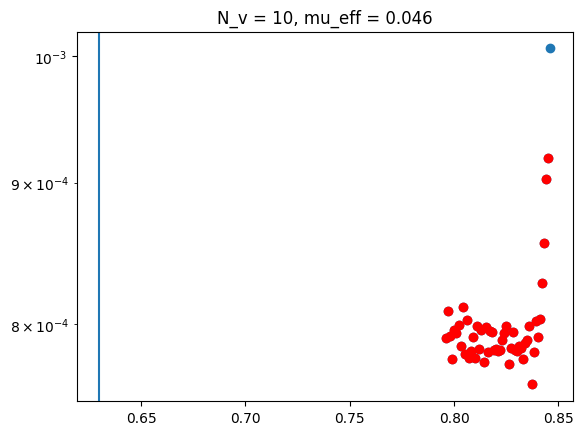

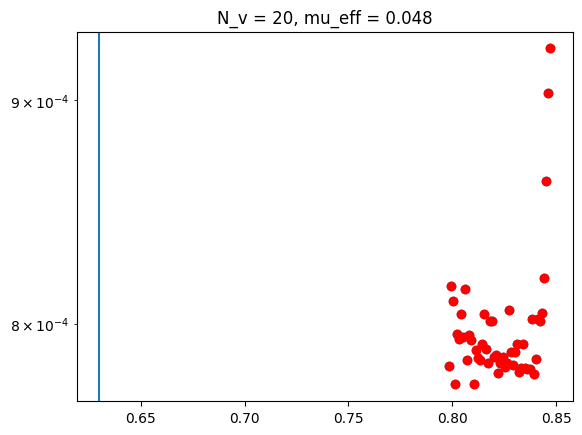

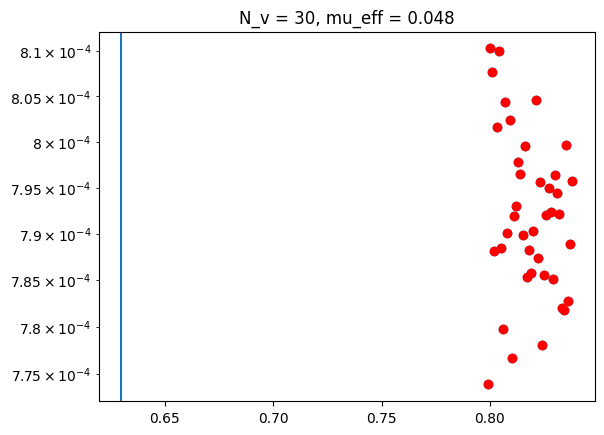

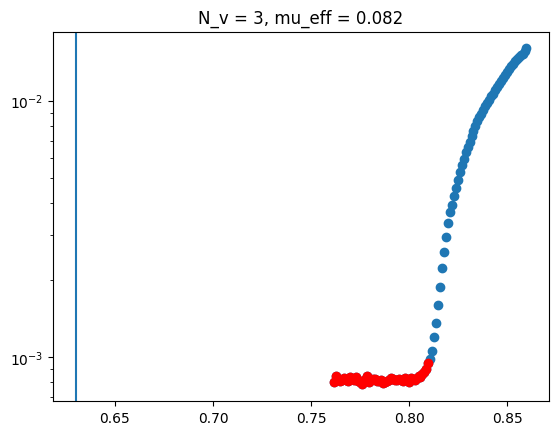

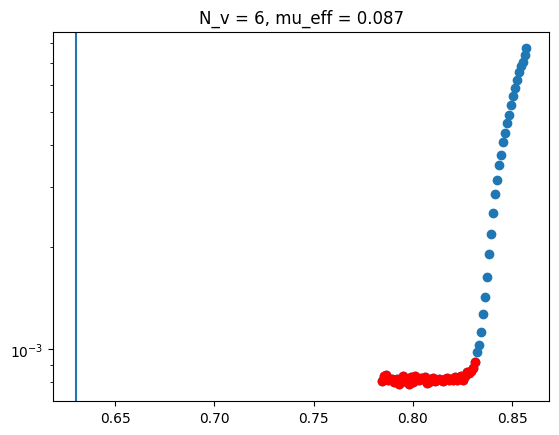

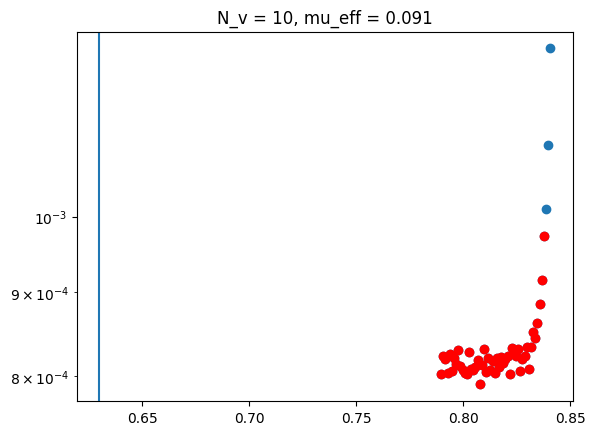

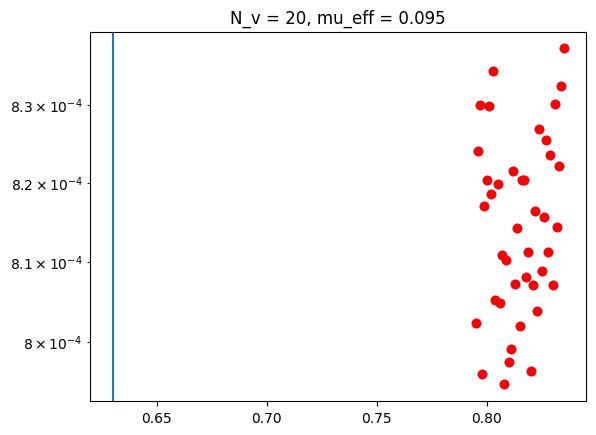

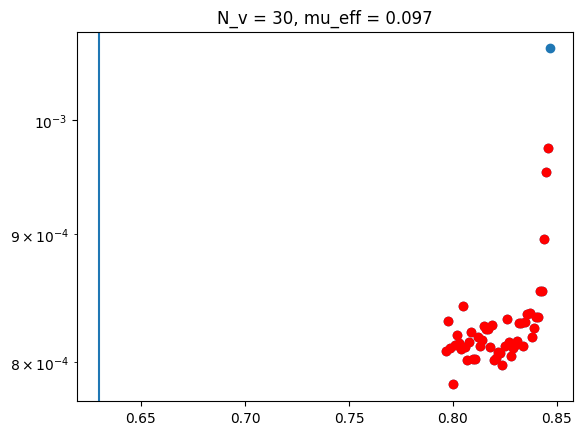

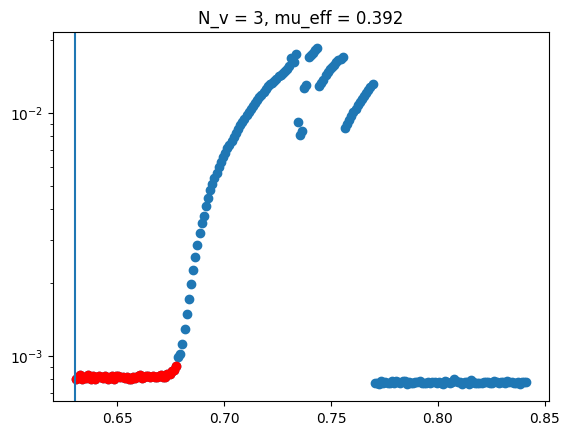

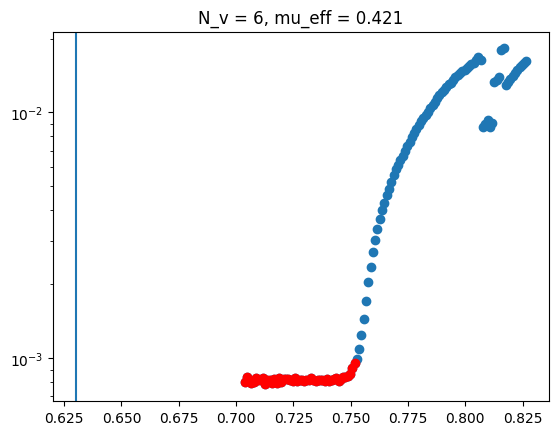

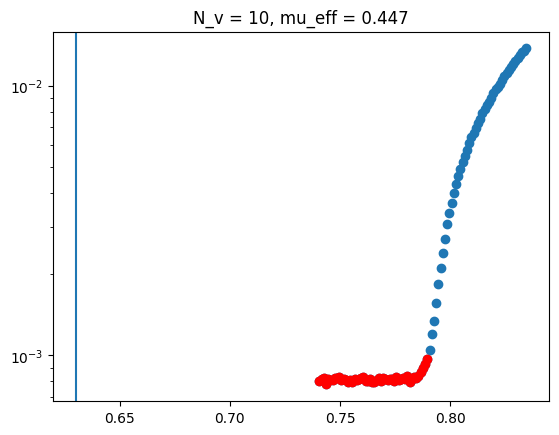

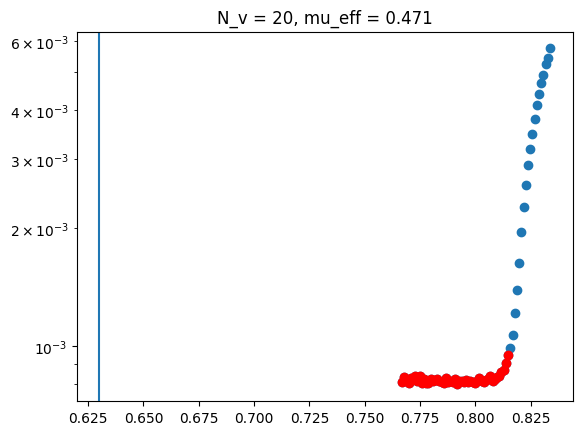

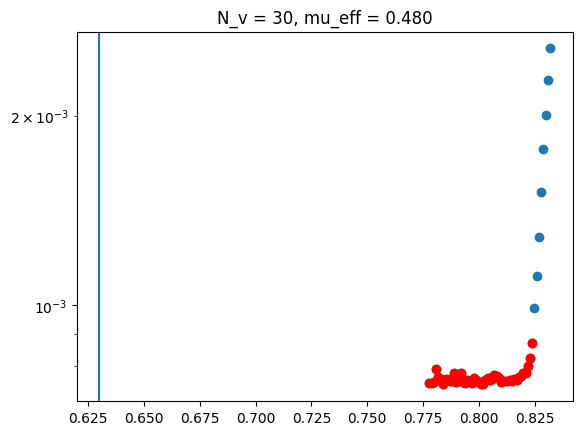

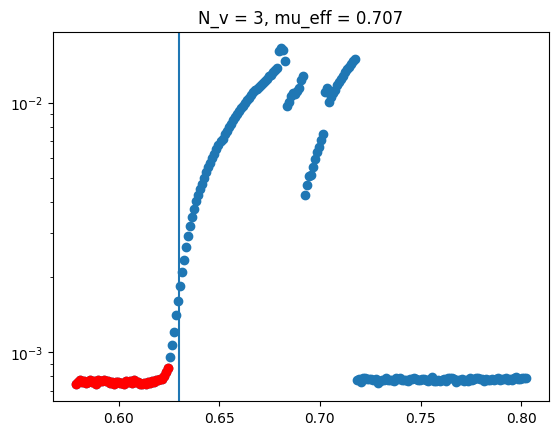

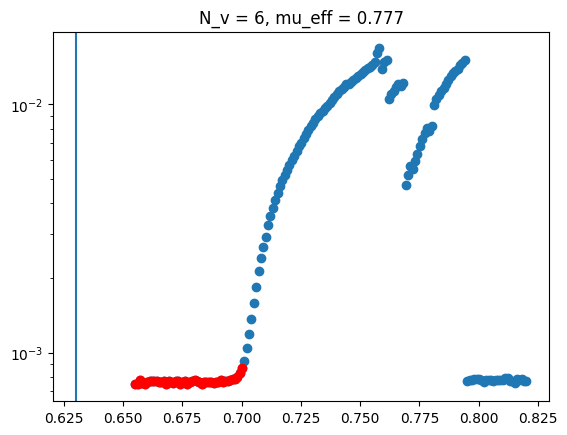

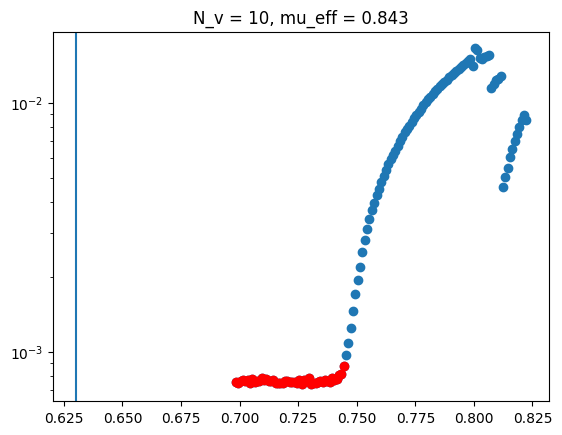

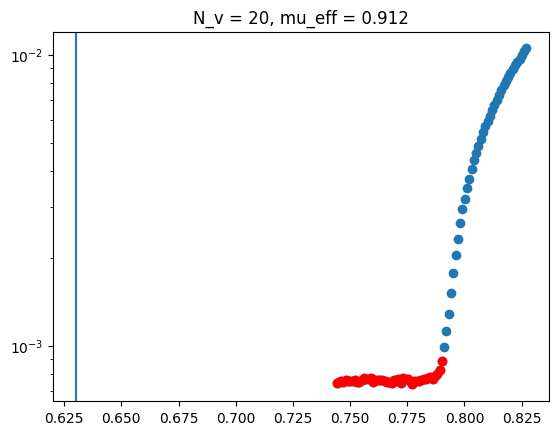

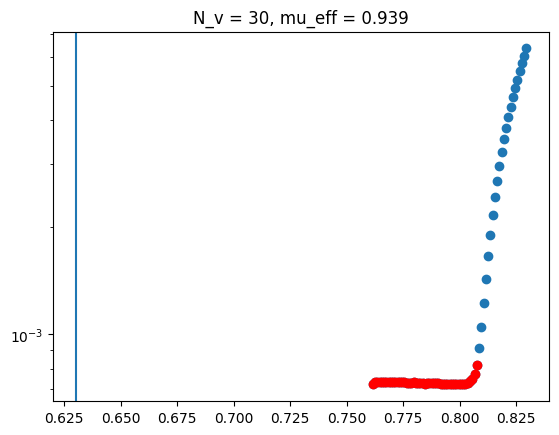

In [4]:
values = {}
trial_id = 0
while True:
    root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small-lower-temp-extra/trial-{trial_id}'
    if not os.path.exists(root):
        break
    trial_id += 1
    i = 0
    while True:
        path = os.path.join(root, f"overlap_{i}.npz")
        if not os.path.exists(path):
            break
        data = np.load(path)
        overlap = data['overlap']
        mu_eff = np.round(data['mu_eff'], 10)
        nv = data['nv']
        phi = np.round(data['packing_fraction'], 10)
        for j in range(overlap.shape[0]):
            mu = mu_eff[j]
            n = nv[j]
            max_phi = get_max_phi(overlap_df, mu, n, 2)
            if phi[j] >= max_phi:  # exclude data with overlaps
                continue
            if (mu, n) not in values:
                values[(mu, n)] = {}
            if phi[j] not in values[(mu, n)]:
                values[(mu, n)][phi[j]] = []
            values[(mu, n)][phi[j]].append(overlap[j])
        i += 1

overlap_cutoff = 1.2
show_plots = True
overlap_data = {}
for mu_n_key in values.keys():
    ov_data, phi_data = [], []
    for i, phi_key in enumerate(values[mu_n_key].keys()):
        ov_data.append(np.mean(np.array(values[mu_n_key][phi_key], dtype=object), axis=0))
        phi_data.append(phi_key)
    ov_data = np.array(ov_data).astype(float)
    phi_data = np.array(phi_data).astype(float)
    order = np.argsort(phi_data)
    phi_data = phi_data[order]
    ov_data = ov_data[order]
    mask = ov_data < np.mean(ov_data[:10]) * overlap_cutoff
    if show_plots:
        plt.scatter(phi_data, ov_data)
    if np.any(~mask):
        split_idx = np.argmax(ov_data)
        phi_data = phi_data[:split_idx]
        ov_data = ov_data[:split_idx]
        mask = ov_data < np.mean(ov_data[:10]) * overlap_cutoff
    ov_data = ov_data[mask]
    phi_data = phi_data[mask]
    if show_plots:
        plt.scatter(phi_data, ov_data, c='r')
        plt.yscale('log')
        plt.axvline(0.63)
        plt.title(f'N_v = {mu_n_key[1] - 1}, mu_eff = {mu_n_key[0]:.3f}')
        plt.show()
    overlap_data[mu_n_key] = {'ov': ov_data, 'phi': phi_data, 'max_phi': np.max(phi_data)}

In [5]:
import pickle
with open('/home/mmccraw/dev/analysis/fall-25/09/run-compression/cutoff_mask.pkl', 'rb') as f:
    cutoff_mask = pickle.load(f)

values = {}
trial_id = 0
while True:
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-final/trial-{trial_id}'; dt = 1e-2; T = 1e-5
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus/trial-{trial_id}'; dt = 1e2; T = 1e-5
    # root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small/trial-{trial_id}'; dt = 1e-2; T = 1e-5
    root = f'/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small-lower-temp/trial-{trial_id}'; dt = 2e-2; T = 1e-6
    if not os.path.exists(root):
        break
    trial_id += 1
    i = 0
    while True:
        path = os.path.join(root, f"shear_modulus_{i}.npz")
        if not os.path.exists(path):
            break
        data = np.load(path)

        G = data['shear_modulus']
        t = data['t'] * dt * np.sqrt(T)
        mu_eff = np.round(data['mu_eff'], 10)
        nv = data['nv']
        phi = np.round(data['packing_fraction'], 10)

        for j in range(G.shape[1]):
            mu = mu_eff[j]
            n = nv[j]
            # max_phi = overlap_data[(mu, n)]['max_phi'] * 100
            max_phi = cutoff_mask[(mu, n)]
            if phi[j] >= max_phi - 0.01:  # exclude data with overlaps
                continue
            if (mu, n) not in values:
                values[(mu, n)] = {}
            if phi[j] not in values[(mu, n)]:
                values[(mu, n)][phi[j]] = []
            values[(mu, n)][phi[j]].append([G[:, j], t])
        i += 1

shear_modulus_data = {}
for mu_n_key in values.keys():
    g_data, t_data, phi_data = [], [], []
    for i, phi_key in enumerate(values[mu_n_key].keys()):
        g, t = np.mean(np.array(values[mu_n_key][phi_key], dtype=object), axis=0)
        g_data.append(g)
        t_data.append(t)
        phi_data.append(phi_key)
    g_data = np.array(g_data).astype(float)
    t_data = np.array(t_data).astype(float)
    phi_data = np.array(phi_data).astype(float)
    shear_modulus_data[mu_n_key] = {'g': g_data, 't': t_data, 'phi': phi_data}

In [6]:
# fit prony series
# test convergence to __spectra__ for varied number of terms in prony series using model data
# WE DONT WANT TO PLOT DATA THAT HAS OVERLAPS: use the overlaps-pe-pressure hp data to cut out packing fractions that have vertex overlaps > 10 * the average low,density data

In [7]:
cmap = plt.cm.viridis
for nv in nv_unique:
    for k in keys:
        if k[1] != 4:
            continue
        mu_eff = k[0]
        phi_norm = plt.Normalize(min(shear_modulus_data[k]['phi']), max(shear_modulus_data[k]['phi']))
        for g, t, phi in zip(shear_modulus_data[k]['g'], shear_modulus_data[k]['t'], shear_modulus_data[k]['phi']):
            plt.plot(t, g / g[0], c=cmap(phi_norm(phi)))
            # plt.plot(t, g, c=cmap(phi_norm(phi)))
        plt.xscale('log')
        plt.title(fr'$N_v$ = {k[1] - 1}, $\mu$ = {k[0]:.3f}')
        plt.show()
    break

NameError: name 'nv_unique' is not defined

/tmp/ipykernel_2273664/290200051.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(shear_modulus_data[k]['phi'], G_0, c=cmap(mu_eff_norm(mu_eff)), s=10)
/tmp/ipykernel_2273664/290200051.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(shear_modulus_data[k]['phi'], tau, c=cmap(mu_eff_norm(mu_eff)), s=10)


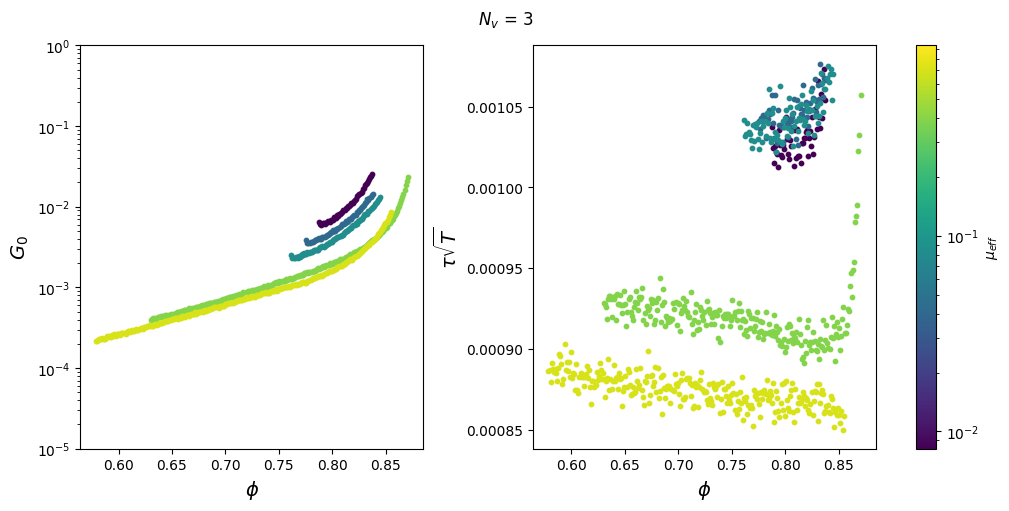

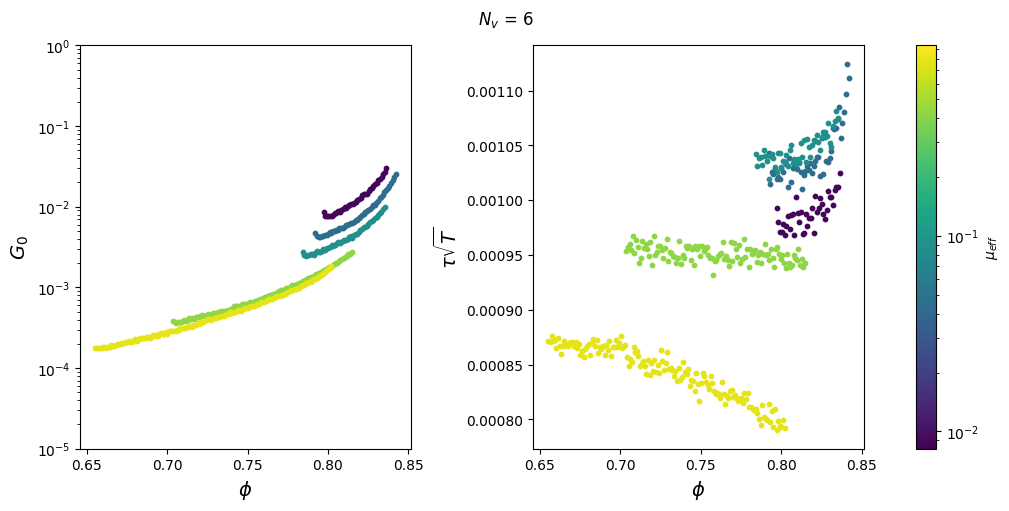

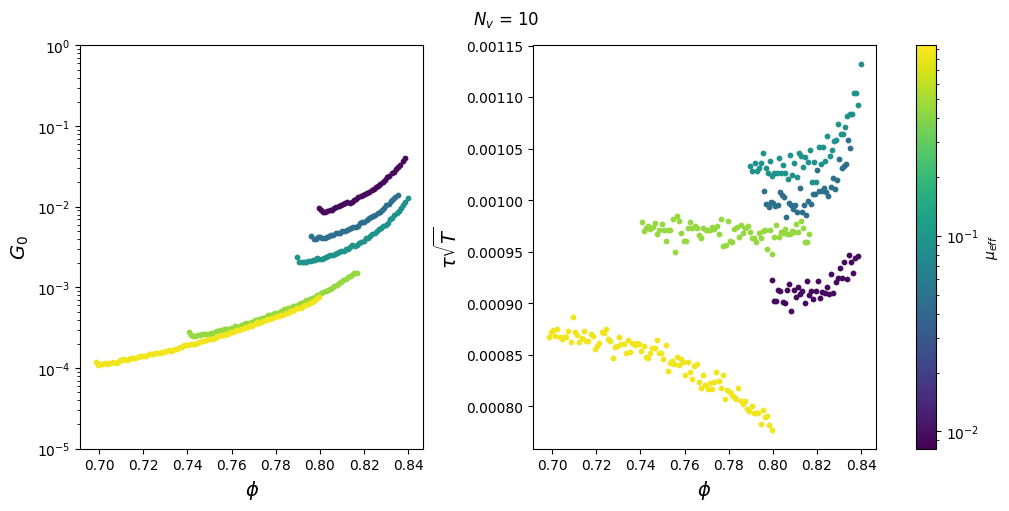

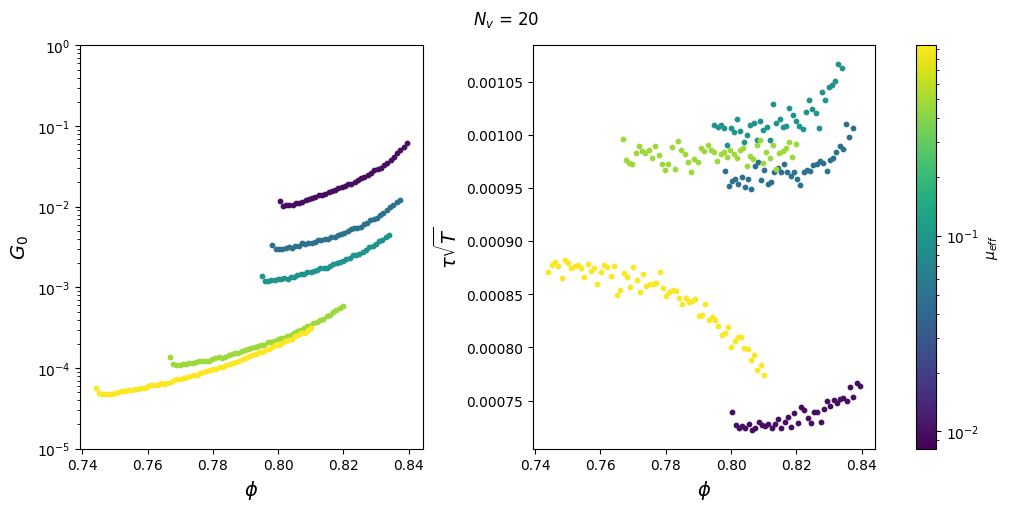

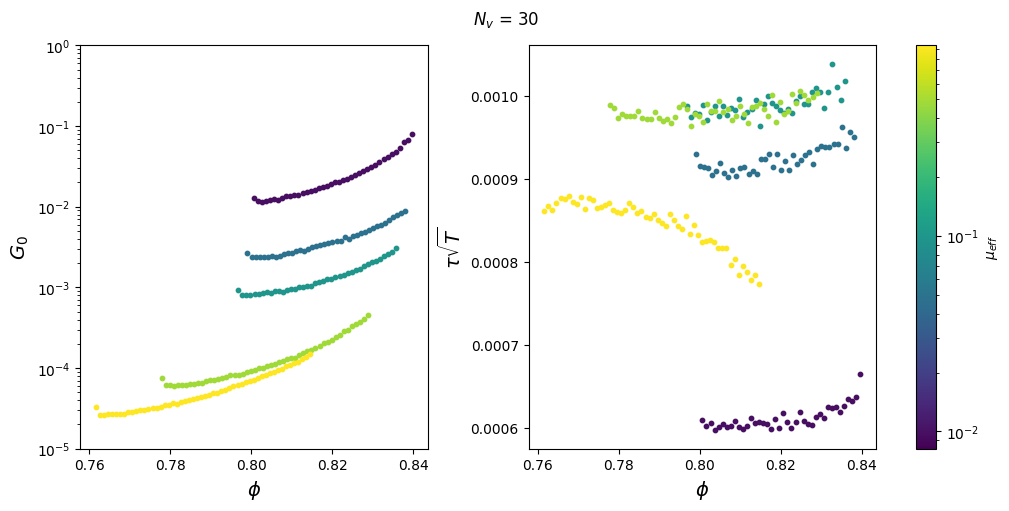

In [34]:
keys = list(shear_modulus_data.keys())
mu_eff_unique = np.unique(np.array(keys)[:, 0])
nv_unique = np.unique(np.array(keys)[:, 1])
mu_eff_norm = LogNorm(min(mu_eff_unique), max(mu_eff_unique))
cmap = plt.cm.viridis
for nv in nv_unique:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
    for k in keys:
        if k[1] != nv:
            continue
        mu_eff = k[0]
        tau = [get_relaxation_time(g / g[0], t) for g, t in zip(shear_modulus_data[k]['g'], shear_modulus_data[k]['t'])]
        G_0 = [g[0] for g in shear_modulus_data[k]['g']]
        ax[0].scatter(shear_modulus_data[k]['phi'], G_0, c=cmap(mu_eff_norm(mu_eff)), s=10)
        ax[1].scatter(shear_modulus_data[k]['phi'], tau, c=cmap(mu_eff_norm(mu_eff)), s=10)
    for a in ax:
        # a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$G_0$', fontsize=14)
    ax[1].set_ylabel(r'$\tau \sqrt{T}$', fontsize=14)
    ax[0].set_ylim(1e-5, 1e0)
    # ax[1].set_ylim(1e-4, 1e-2)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_unique)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.savefig(f'figures/G0_tau_NV_{nv - 1}.png', dpi=300)
    plt.show()



In [ ]:
# measure actual overlaps - cut out data using that
# measure angular velocity

In [42]:
p = '/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small-lower-temp-extra/trial-0/dynamics_0'
data = load(p, location=['init', 'final'], load_trajectory=True, load_full=False)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus-small-lower-temp-extra/trial-0/dynamics_0/meta.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from scipy.spatial import cKDTree
def nearest_neighbor_pairs(pos, box_size, rmax, unique_radius=None, radii=None):
    tree = cKDTree(np.mod(pos, box_size), boxsize=box_size)
    pairs = np.fromiter(tree.query_pairs(r=rmax), dtype=np.dtype([('i',np.int32),('j',np.int32)]))
    i = pairs['i']
    j = pairs['j']
    if unique_radius is not None:
        mask = (radii[i] == unique_radius) & (radii[j] == unique_radius)
        i = i[mask]
        j = j[mask]
    return i, j

rmax = 3

neighbor_list_by_frame = []
neighbor_offset_by_frame = []

for i in tqdm(range(data.trajectory.num_frames()), desc='Building Neighbor Lists'):
    neighbor_list = []
    neighbor_size = []
    for sid in np.unique(data.system_id):
        pos = data.trajectory[i].pos[data.system_id == sid]
        box_size = data.box_size[sid]
        radii = data.rad[data.system_id == sid]
        unique_radius = np.min(radii)
        pairs_i, pairs_j = nearest_neighbor_pairs(pos, box_size, rmax, unique_radius, radii)
        # dr = pos[pairs_i] - pos[pairs_j]
        # dr -= np.round(dr / box_size) * box_size
        # distances = np.linalg.norm(dr, axis=1)
        pairs_i += data.system_offset[sid]
        pairs_j += data.system_offset[sid]
        neighbor_list.append(np.column_stack([pairs_i, pairs_j]))
        neighbor_size.append(len(pairs_i))
    neighbor_list_by_frame.append(np.concatenate(neighbor_list))
    neighbor_offset_by_frame.append(np.concatenate([[0], np.cumsum(neighbor_size)]))

Building Neighbor Lists: 100%|██████████| 1000/1000 [00:04<00:00, 241.09it/s]


In [192]:
@requires_fields('angular_vel')
def angle_kernel(indices, get_frame, system_id, system_size, neighbor_list_by_frame, neighbor_offset_by_frame):
    t0, t1 = indices
    w0 = get_frame(t0)['angular_vel']
    w1 = get_frame(t1)['angular_vel']
    neighbor_list = neighbor_list_by_frame[t0]
    neighbor_offset = neighbor_offset_by_frame[t0]
    return np.add.reduceat(w0[neighbor_list[:, 0]] * w1[neighbor_list[:, 1]], neighbor_offset[:-1])


In [193]:
bins = LagBinsPseudoLog.from_source(data.trajectory)
res = run_binned(angle_kernel, data.trajectory, bins, kernel_kwargs={'system_id': data.system_id, 'system_size': data.system_size, 'neighbor_list_by_frame': neighbor_list_by_frame, 'neighbor_offset_by_frame': neighbor_offset_by_frame}, show_progress=True, n_workers=10)

Binned accumulation:   0%|          | 0/22005 [00:00<?, ?it/s]

Binned accumulation: 100%|██████████| 22005/22005 [00:01<00:00, 14783.12it/s]


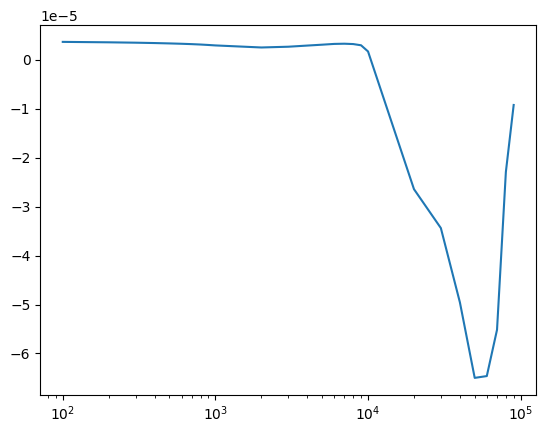

In [210]:
plt.plot(bins.values(), res.mean[:, 6])
plt.xscale('log')


In [34]:
name = 'dynamics_40'
data = load(f'/home/mmccraw/dev/data/10-01-25/short-test/trial-0/{name}',
location=['init', 'final'], load_trajectory=True, load_full=True)
print(data.packing_fraction[24])

Loading trajectory: 100%|██████████| 4/4 [00:00<00:00, 14.90it/s]

0.8016060433569249


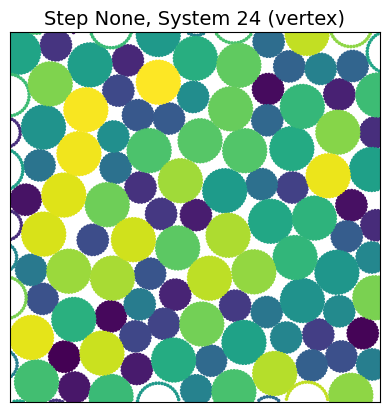

In [33]:
draw_particles_frame(None, plt.gca(), data, 24, True, 'vertex', 'viridis', None)

In [35]:
desired_frames = 100
steps_to_animate = downsample(data, desired_frames)

# Define the output path
output_path = f"animations-new/{name}.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=data,
    system_id=24,
    use_pbc=True,
    which='vertex',
    cmap_name='viridis'
)

Creating animation:   0%|          | 0/100 [00:00<?, ?it/s]

Saving animation to animations-new/dynamics_40.gif...


Creating animation: 101it [01:17,  1.30it/s]                         

Animation saved successfully!
